In [343]:
from collections import Counter
import pickle
import itertools
import string
from rich import print as rprint

import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import time
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,IFrame,HTML,Image

import pickle
from math import gcd
from itertools import product
from tqdm import tqdm

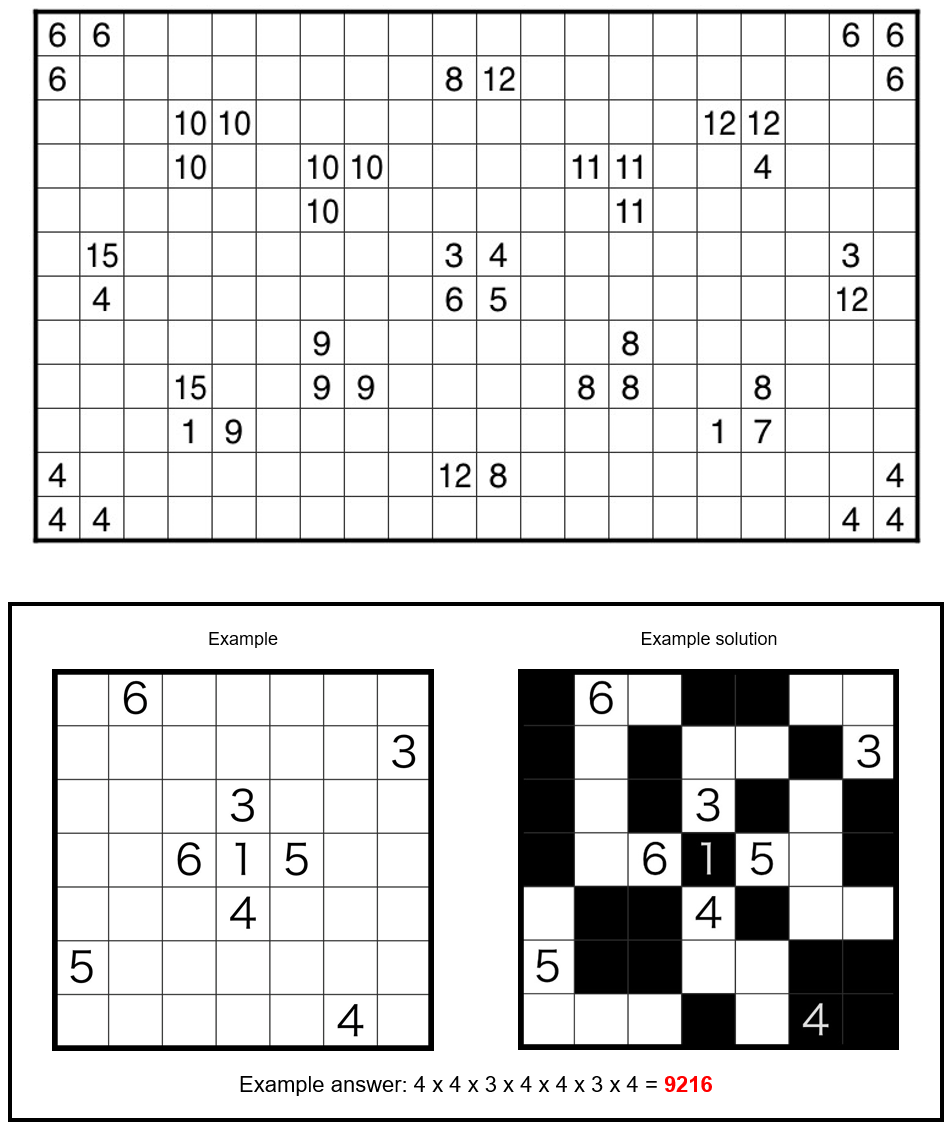

### Choco Banana

If we shade a subset of the cells in the above grid, we partition the
cells into orthogonally connected
regions
of shaded and unshaded
cells. The goal of this puzzle is to shade the cells so that
all regions of shaded cells are rectangular,
all regions of unshaded cells are
not
rectangular, and

In [3]:
url='https://www.janestreet.com/puzzles/current-puzzle/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y = [text for text in soup.body.stripped_strings]
display(Image('https://www.janestreet.com/puzzles/choco-banana.png',width=600))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[9:16]))))

### Absolute Rules
- a 1 is always shaded black
- a region may only go through at most one unique number
- black regions must be square
    - odd numbers can only be black if forming a straight line
- white regions must not be square
- if there are two different numbers orthogonal to eachother, then they must have different shades
- if a region is formed, then immediately all orthogonal grids must be set to the opposite shade (this will greatly speed up constraint checking)

In [348]:
# reference_grid = np.array([
#     [0, 0, 0, 0],
#     [0, 0, 0, 3],
#     [3, 0, 0, 0],
#     [1, 5, 0, 0],
#     [4, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 4, 0],
# ])
# reference_grid = np.array([
#     [0, 0, 3, 0, 7],
#     [0, 0, 7, 0, 0],
#     [0, 0, 5, 0, 0],
#     [0, 0, 5, 0, 0],
# ])

reference_grid = np.array([
    [6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6],
    [6,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12,  0,  0,  0,  0,  0,  0,  0,  0,  6],
    [0,  0,  0, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  0,  0,  0],
    [0,  0,  0, 10,  0,  0, 10, 10,  0,  0,  0,  0, 11, 11,  0,  0,  4,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
    [0, 15,  0,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,  0,  3,  0],
    [0,  4,  0,  0,  0,  0,  0,  0,  0,  6,  5,  0,  0,  0,  0,  0,  0,  0, 12,  0],
    [0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0],
    [0,  0,  0, 15,  0,  0,  9,  9,  0,  0,  0,  0,  8,  8,  0,  0,  8,  0,  0,  0],
    [0,  0,  0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  7,  0,  0,  0],
    [4,  0,  0,  0,  0,  0,  0,  0,  0, 12,  8,  0,  0,  0,  0,  0,  0,  0,  0,  4],
    [4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4],
])

# reference_grid = np.array([
#     [0,6,0,0,0,0,0],
#     [0,0,0,0,0,0,3],
#     [0,0,0,3,0,0,0],
#     [0,0,6,1,5,0,0],
#     [0,0,0,4,0,0,0],
#     [5,0,0,0,0,0,0],
#     [0,0,0,0,0,4,0]
# ])

In [349]:
import numpy as np
from copy import deepcopy

# These directions represent up, down, left, and right moves
DIRECTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def plot_points_on_grid(points, grid_size):
    grid = np.ones(grid_size)
    for point in points:
        grid[point[0]][point[1]] = 0
    plt.imshow(grid, cmap='gray')
    plt.show()

def dfs(grid, allocated_grid, location, n, path, all_paths, is_white):
    # If the path is of length n and includes the starting location, add it to all_paths
    if len(path) == n and location in path:
        if is_white and not is_rectangle(str(sorted(path))):
            all_paths.add(str(sorted(path)))
        elif not is_white and is_rectangle(str(sorted(path))):
            all_paths.add(str(sorted(path)))
        return

    # If the path is already of length n but doesn't include the starting location, stop searching this path
    if len(path) == n:
        return

    for dx, dy in DIRECTIONS:
        x, y = location[0] + dx, location[1] + dy

        if (0 <= x < len(grid) and 0 <= y < len(grid[0]) 
            and (grid[x][y] != -1 if is_white else 1) 
            and (x, y) not in path 
            and (reference_grid[x][y] == n or reference_grid[x][y] == 0)
            and not allocated_grid[x][y]):

            new_path = path.copy()
            new_path.append((x, y))
            allocated_grid[x][y] = True
            dfs(grid, allocated_grid, (x, y), n, new_path, all_paths, is_white)
            allocated_grid[x][y] = False  # backtrack

    # If the path is less than n, try to extend the path by searching from every location in the path
    if len(path) < n:
        for p in path:
            for dx, dy in DIRECTIONS:
                x, y = p[0] + dx, p[1] + dy

                if (0 <= x < len(grid) and 0 <= y < len(grid[0]) 
                    and (grid[x][y] != -1 if is_white else 1) 
                    and (x, y) not in path 
                    and (reference_grid[x][y] == n or reference_grid[x][y] == 0) 
                    and not allocated_grid[x][y]):

                    new_path = path.copy()
                    new_path.append((x, y))
                    allocated_grid[x][y] = True
                    dfs(grid, allocated_grid, (x, y), n, new_path, all_paths, is_white)
                    allocated_grid[x][y] = False  # backtrack



def display_grid(allocation_grid, reference_grid):
    if allocation_grid.shape != reference_grid.shape:
        raise ValueError("Both grids should have the same shape")

    fig, ax = plt.subplots()

    ax.axis('off')

    sns.heatmap(allocation_grid, cmap=['black', 'pink', 'white'], linewidths=0.1, 
                ax=ax, cbar=False, square=True, linecolor='gray')

    for i in range(reference_grid.shape[0]):
        for j in range(reference_grid.shape[1]):
            if reference_grid[i, j] != 0:
                ax.text(j+0.5, i+0.5, str(int(reference_grid[i, j])),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8,
                        color='black' if allocation_grid[i, j] != -1 else 'white')

    plt.show()


def is_rectangle(path_str):
    path = eval(path_str)
    x_min = min(point[0] for point in path)
    x_max = max(point[0] for point in path)
    y_min = min(point[1] for point in path)
    y_max = max(point[1] for point in path)

    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            if (x, y) not in path:
                return False

    return True

def find_closest_cells(reference_grid, x, y):
    non_zero_cells = []

    for i in range(len(reference_grid)):
        for j in range(len(reference_grid[0])):
            if reference_grid[i][j] != 0:
                distance = abs(i - x) + abs(j - y)
                non_zero_cells.append((distance, (i,j)))

    non_zero_cells.sort()
    closest_cells_values = [position for _, position in non_zero_cells]

    return closest_cells_values


def find_regions(grid, allocated_grid, location, n, is_white):
    # Store all unique paths of length n
    all_paths = set()
    dfs(grid, allocated_grid, location, n, [location], all_paths, is_white)

    # Create grids from paths
    unique_grids = []
    for path_str in all_paths:
        path = eval(path_str)
        new_grid = deepcopy(grid)  # Create a deep copy of the original grid
        new_allocated_grid = deepcopy(allocated_grid)  # Create a deep copy of the original grid
        invalid = False  # Flag to check if overwriting is valid
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if (i, j) in path:
                    # color the region with the designated color: 1=white, -1=black
                    if new_grid[i][j] != 0 and new_grid[i][j] != (1 if is_white else -1):
                        invalid = True
                        break
                    new_grid[i][j] = 1 if is_white else -1
                    # now, set the TRUE allocation for the region as well
                    new_allocated_grid[i][j] = True
                elif any((i+dx, j+dy) in path for dx, dy in DIRECTIONS if 0 <= i+dx < grid.shape[0] and 0 <= j+dy < grid.shape[1]):
                    # color the orthogonally connected neighbors with the opposite color: 1=white, -1=black
                    if new_grid[i][j] != 0 and new_grid[i][j] != (-1 if is_white else 1):
                        invalid = True
                        break
                    new_grid[i][j] = -1 if is_white else 1
            if invalid:
                break
        if not invalid:
            unique_grids.append((new_grid, new_allocated_grid))

    return unique_grids


def solve(grid, allocated_grid, remaining):
    # Base case: no remaining cells to fill, so return the grid as a solution
    if not remaining:
        return [grid]

    solutions = []
    # print(remaining)
    # Instead of looping over all cells, we'll start with the first cell in the remaining set
    cell = next(iter(remaining))
    
    x, y = cell
    n = reference_grid[x][y]
    if grid[x][y] == 1:
        is_white_choices = [True]
    elif grid[x][y] == -1:
        is_white_choices = [False]
    else:
        is_white_choices = [True, False]
    
    for is_white in is_white_choices:
        new_grids = find_regions(grid, allocated_grid, (x, y), n, is_white)
        # print(f'new_grids is!!: \n{[new_grid[0] for new_grid in new_grids]}')
        # print(f'new_grids is!!: \n{[new_grid[1] for new_grid in new_grids]}')
        for new_grid, new_allocated_grid in new_grids:
            # Remove filled cells from the remaining set
            new_remaining = remaining.copy()
            remaining_to_loop = new_remaining.copy() # need to make copy because unable to dynamically remove and loop over list elements
            for i,j in remaining_to_loop:
                if new_allocated_grid[i][j] == True: # has already been assigned
                    # print(f'{new_allocated_grid=}')
                    # print(f'i,j: {i},{j}')
                    # print(f'{new_remaining=}')
                    new_remaining.remove((i, j))
                    # print(f'{new_remaining=}\n\n')
                    
            
            # Recursively solve the rest of the grid
            # display(new_grid)
            # display(reference_grid)
            # display_grid(new_grid, reference_grid)
            solutions += solve(new_grid, new_allocated_grid, new_remaining)

    return solutions


In [350]:
display(reference_grid)
grid = np.zeros_like(reference_grid)
display(grid)
allocated_grid = np.zeros_like(reference_grid, dtype=bool)
display(allocated_grid)

array([[ 6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  6,  6],
       [ 6,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12,  0,  0,  0,  0,  0,
         0,  0,  0,  6],
       [ 0,  0,  0, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,
        12,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0, 10, 10,  0,  0,  0,  0, 11, 11,  0,  0,
         4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0, 11,  0,  0,
         0,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,
         0,  0,  3,  0],
       [ 0,  4,  0,  0,  0,  0,  0,  0,  0,  6,  5,  0,  0,  0,  0,  0,
         0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  8,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0, 15,  0,  0,  9,  9,  0,  0,  0,  0,  8,  8,  0,  0,
         8,  0,  0,  0],
       [ 0,  0,  0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         7,  0,  0,  0],
       [ 4,  0,  0,  0,  0,  0

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [Fa

In [352]:
grid = np.zeros_like(reference_grid)
allocated_grid = np.zeros_like(reference_grid, dtype=bool)
x, y = 9, 15
remaining = find_closest_cells(reference_grid, x, y)
print(remaining)

# Measure execution time
start_time = time.time()
# ===============================================
solutions = solve(grid, allocated_grid, remaining)
# ===============================================
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

filename = "solutions.pickle"
with open(filename, "wb") as file:
    pickle.dump(solutions, file)


[(9, 15), (9, 16), (8, 16), (8, 13), (7, 13), (8, 12), (10, 19), (11, 18), (6, 18), (10, 10), (11, 19), (2, 15), (3, 16), (4, 13), (5, 18), (10, 9), (2, 16), (3, 13), (6, 10), (3, 12), (5, 10), (6, 9), (8, 7), (5, 9), (8, 6), (7, 6), (9, 4), (0, 18), (1, 19), (9, 3), (0, 19), (1, 10), (8, 3), (1, 9), (3, 7), (4, 6), (3, 6), (10, 0), (11, 1), (6, 1), (11, 0), (2, 4), (3, 3), (5, 1), (2, 3), (0, 1), (1, 0), (0, 0)]


In [332]:
import numpy as np

def dfs(arr, visited, i, j, value):
    stack = [(i, j)]
    points = []
    
    while stack:
        i, j = stack.pop()
        if i < 0 or i >= len(arr) or j < 0 or j >= len(arr[0]) or visited[i][j] or arr[i][j] != value:
            continue
        visited[i][j] = True
        points.append((i, j))
        for x, y in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]:
            stack.append((x, y))
    return points

def is_rectangle(arr, points, value):
    min_i, max_i = min(point[0] for point in points), max(point[0] for point in points)
    min_j, max_j = min(point[1] for point in points), max(point[1] for point in points)
    
    for i in range(min_i, max_i+1):
        for j in range(min_j, max_j+1):
            if arr[i][j] != value:
                return False
    for point in points:
        if point[0] < min_i or point[0] > max_i or point[1] < min_j or point[1] > max_j:
            return False
    return True


def check_rectangularity(arr):
    visited = [[False]*len(arr[0]) for _ in range(len(arr))]
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if arr[i][j] in (1, -1) and not visited[i][j]:
                points = dfs(arr, visited, i, j, arr[i][j])
                if (arr[i][j] == 1 and not is_rectangle(arr, points, 1)) or (arr[i][j] == -1 and is_rectangle(arr, points, -1)):
                    return False
    return True


In [333]:
solutions[24]

array([[-1,  1,  1, -1, -1,  1,  1],
       [-1,  1, -1,  1,  1, -1,  1],
       [-1,  1, -1,  1, -1, -1, -1],
       [-1,  1,  1, -1,  1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1],
       [ 1, -1, -1,  1,  1, -1, -1],
       [ 1,  1,  1, -1,  1, -1, -1]])

In [334]:
rectangle_checks = [check_rectangularity(solution) for solution in solutions]
rectangle_checks

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [325]:
solutions[24]

array([[-1,  1,  1, -1, -1,  1,  1],
       [-1,  1, -1,  1,  1, -1,  1],
       [-1,  1, -1,  1, -1, -1, -1],
       [-1,  1,  1, -1,  1,  1,  1],
       [ 1, -1, -1,  1, -1,  1,  1],
       [ 1, -1, -1,  1,  1, -1, -1],
       [ 1,  1,  1, -1,  1, -1, -1]])

1


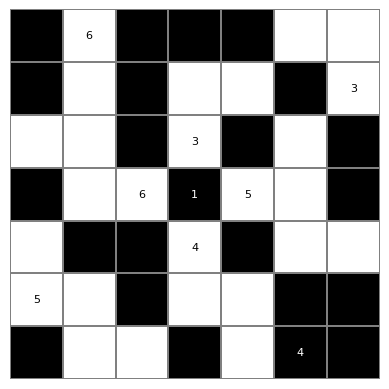

2


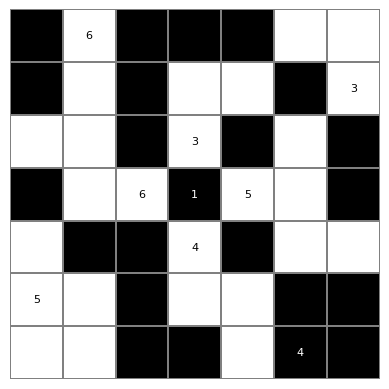

3


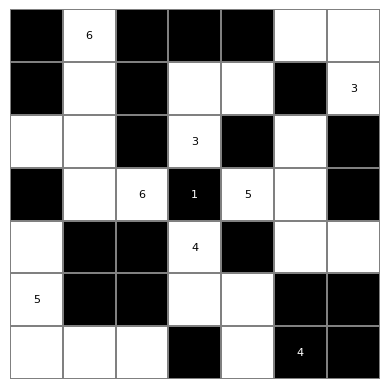

4


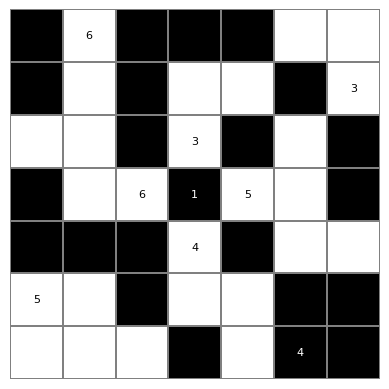

5


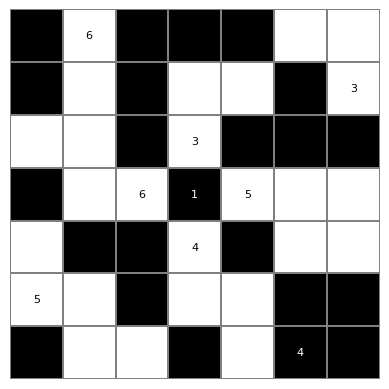

6


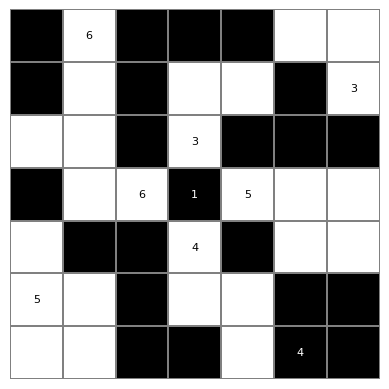

7


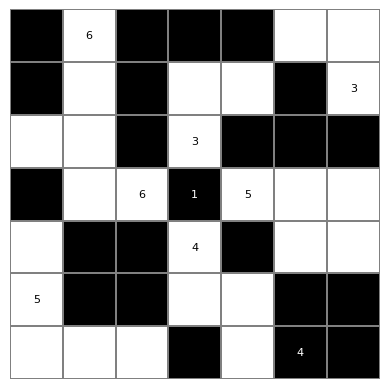

8


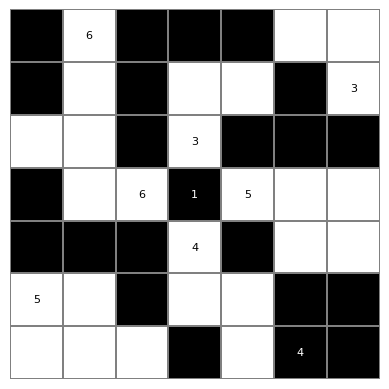

9


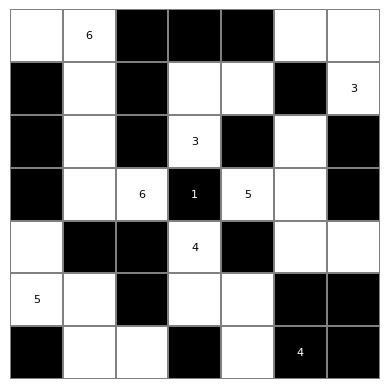

10


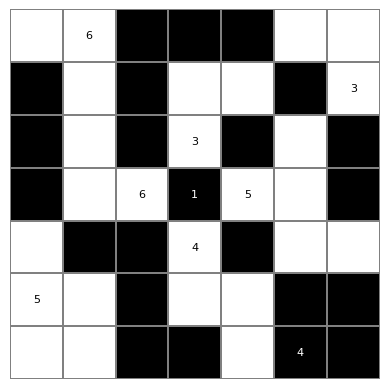

11


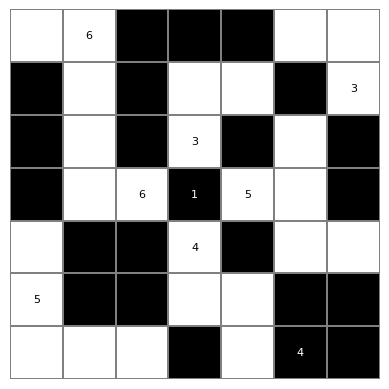

12


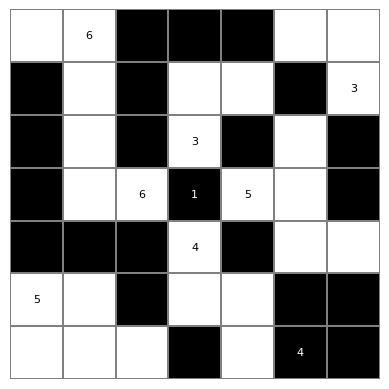

13


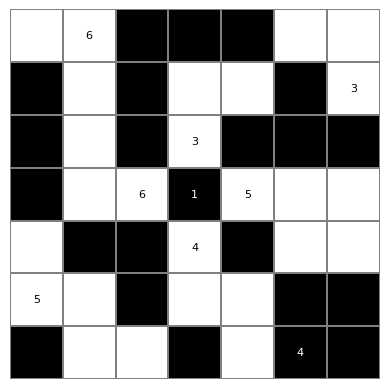

14


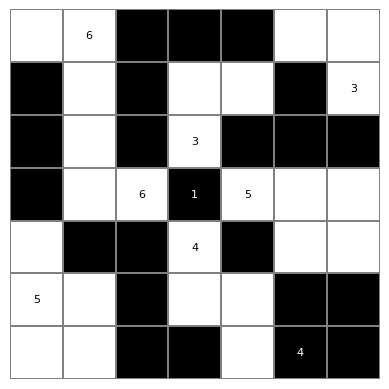

15


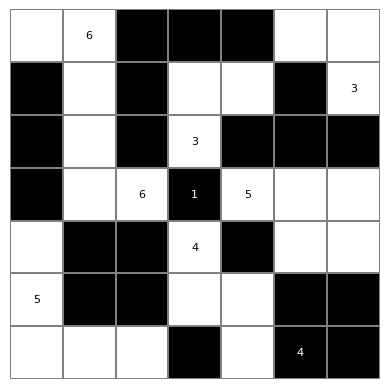

16


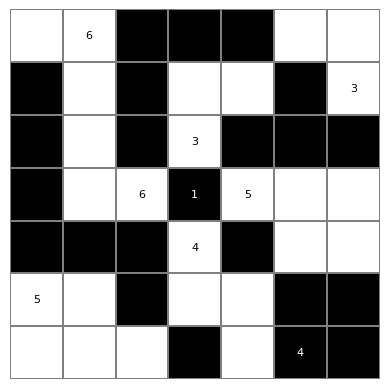

17


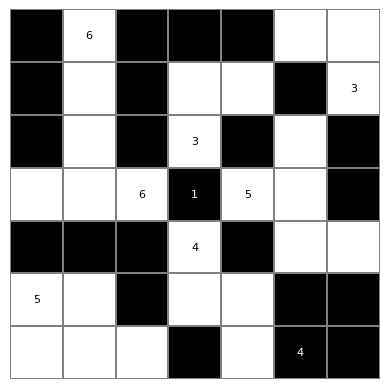

18


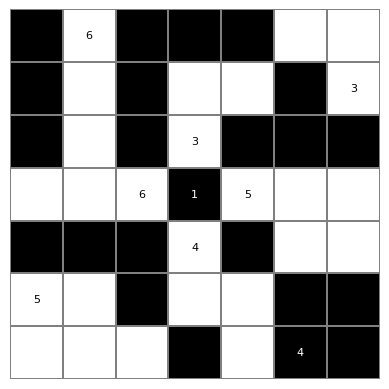

19


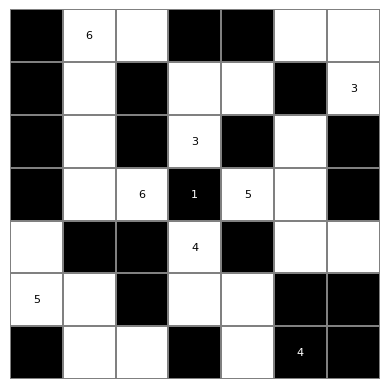

20


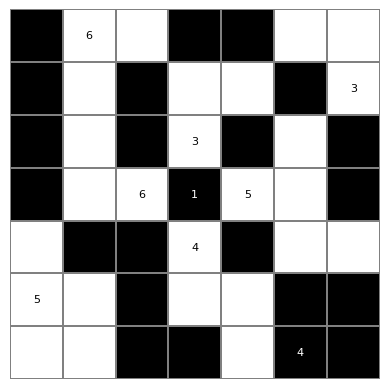

21


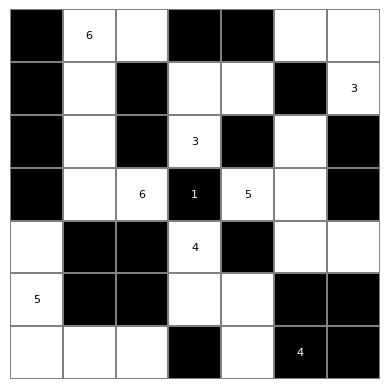

22


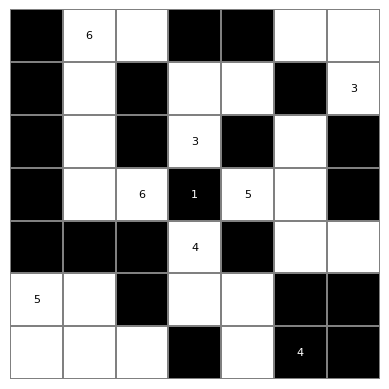

23


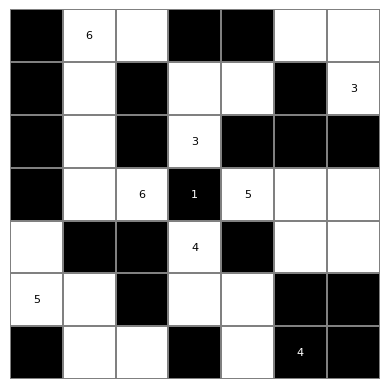

24


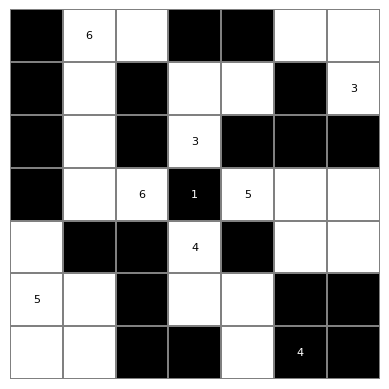

25


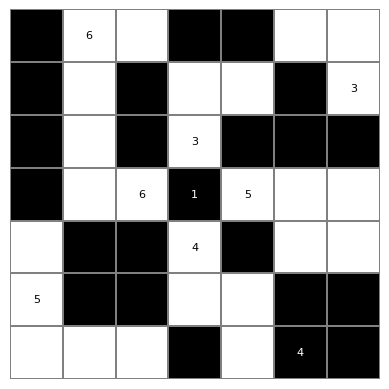

26


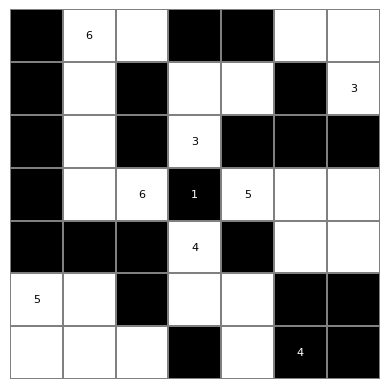

27


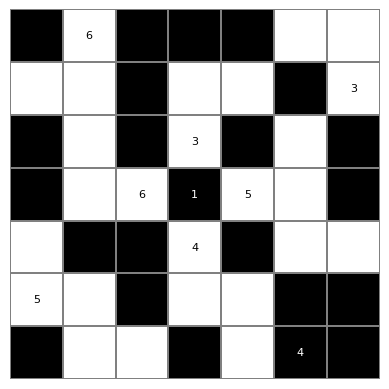

28


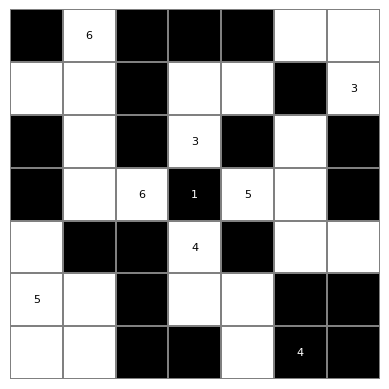

29


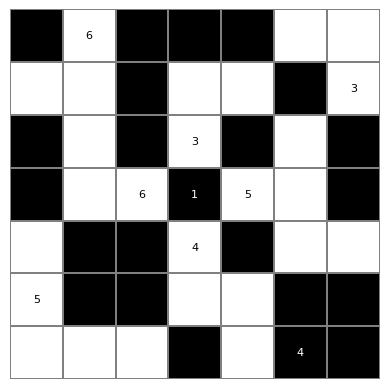

30


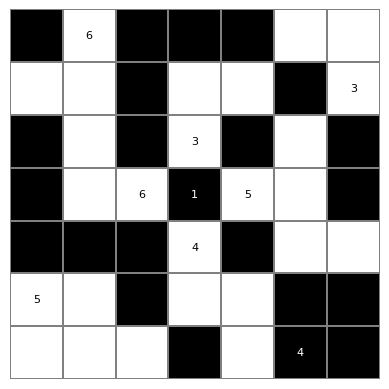

31


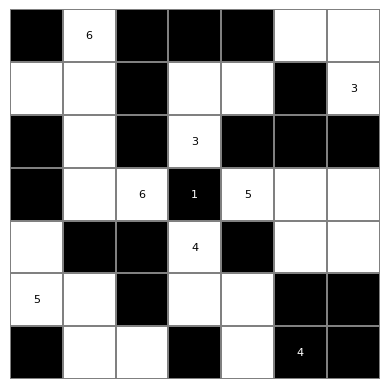

32


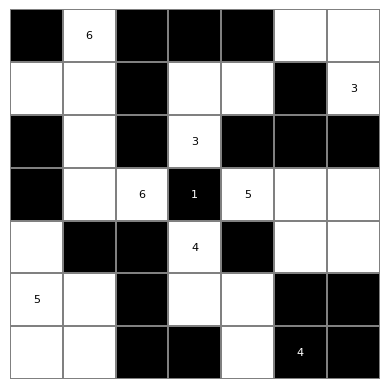

33


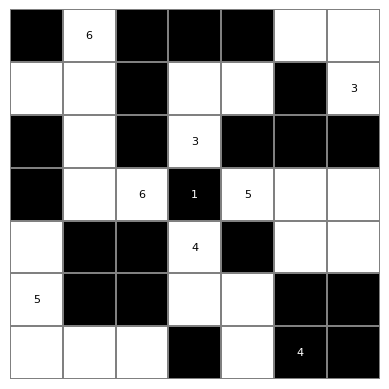

34


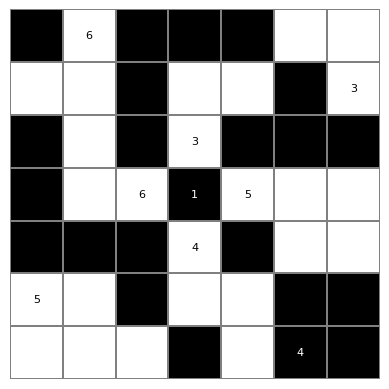

In [321]:
for i, solution in enumerate(solutions, 1):
    print(i)
    display_grid(solution, reference_grid)

In [273]:
grid = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

allocated_grid = np.array([
    [False, False, False, False],
    [False, False, False, False],
    [False, False, False, False],
    [ True, False, False, False],
    [False, False, False, False],
    [False, False, False, False],
    [False, False, False, False],
])

all_paths = set()
is_white = True
location = (3,1)
n=5

dfs(
    grid, allocated_grid, location, n, [location], all_paths, is_white
)

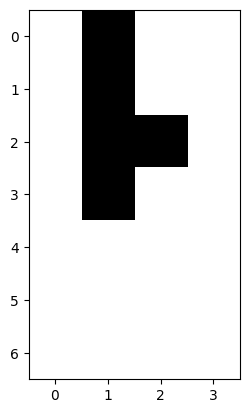

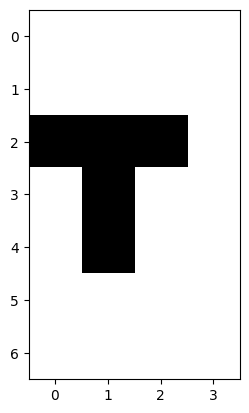

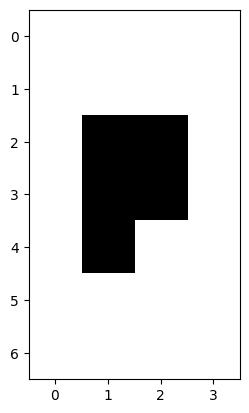

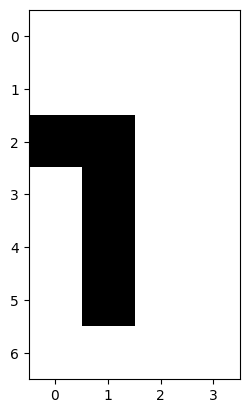

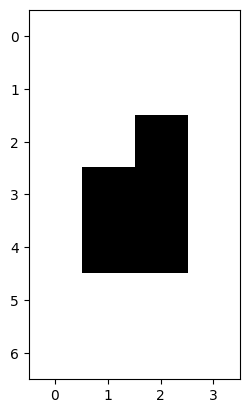

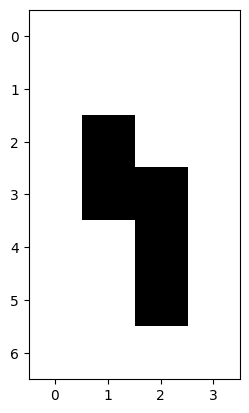

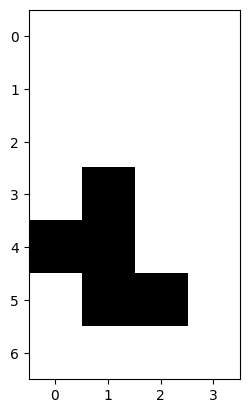

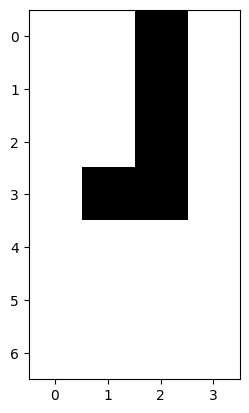

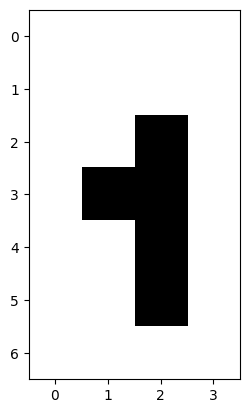

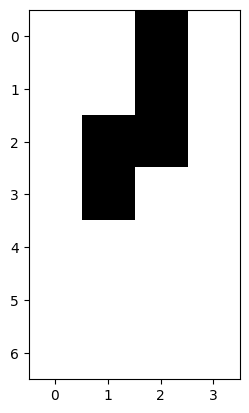

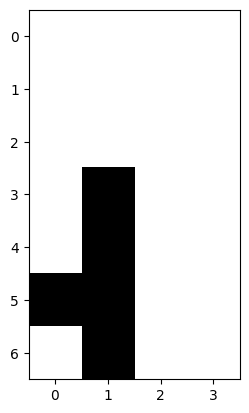

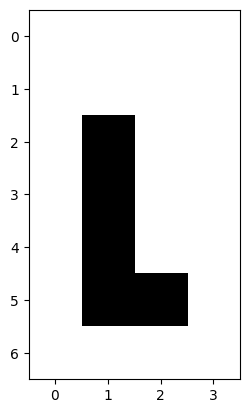

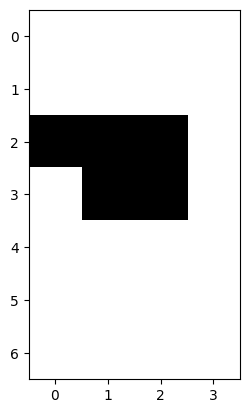

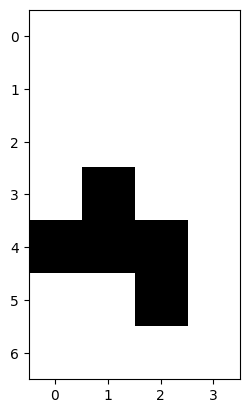

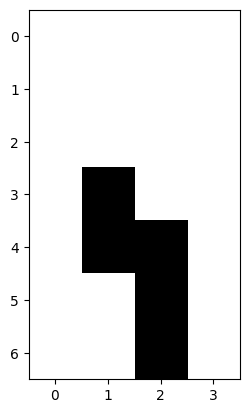

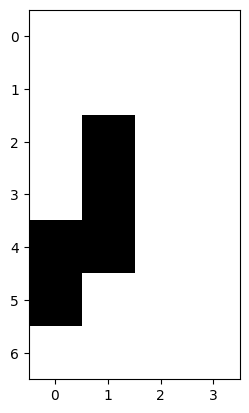

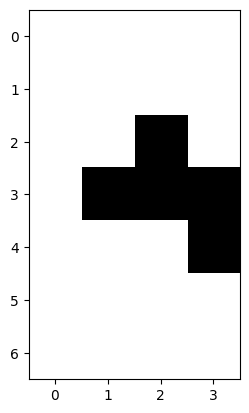

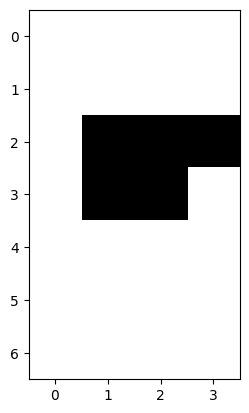

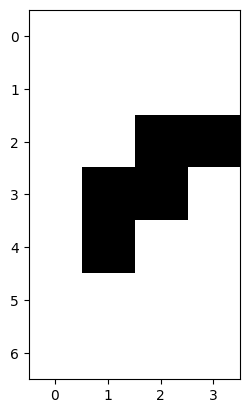

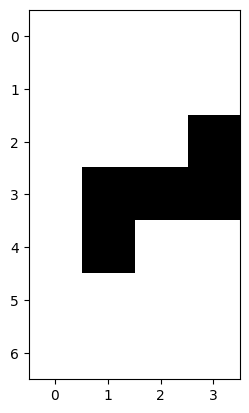

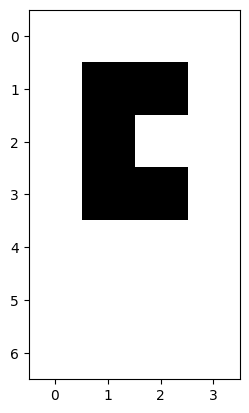

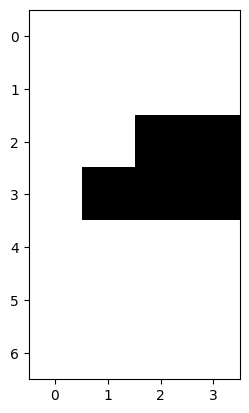

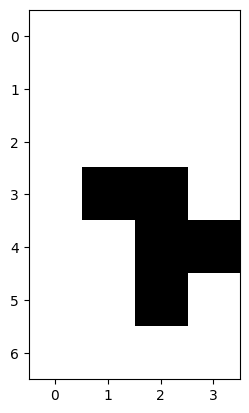

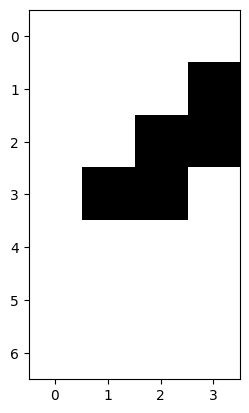

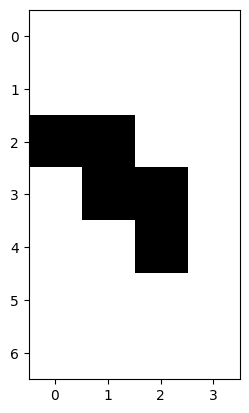

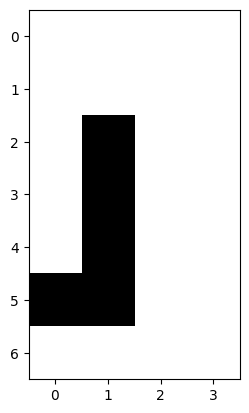

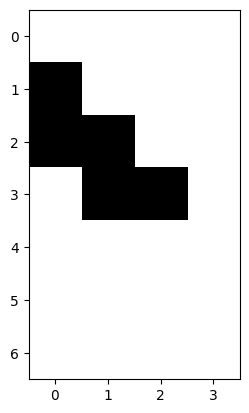

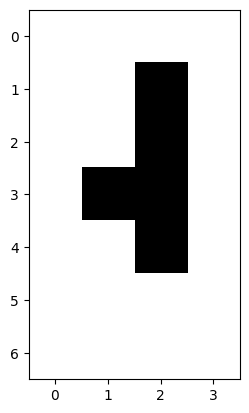

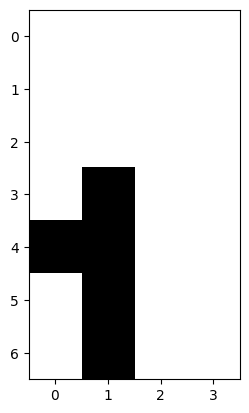

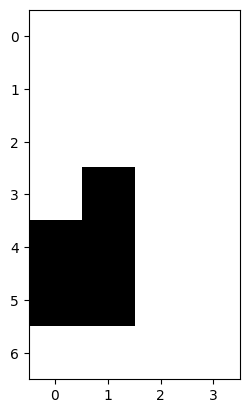

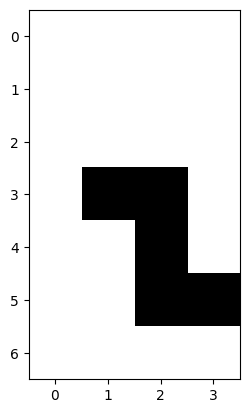

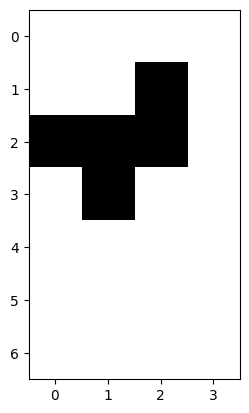

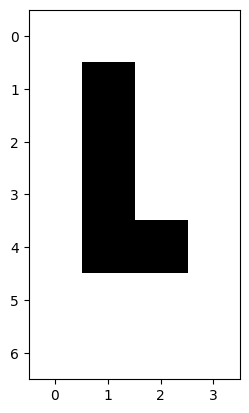

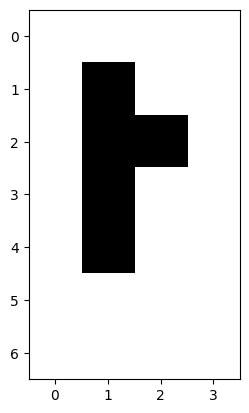

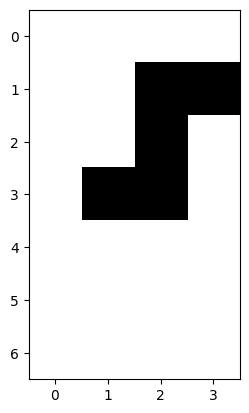

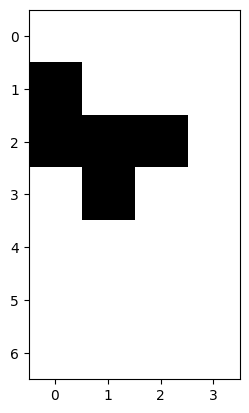

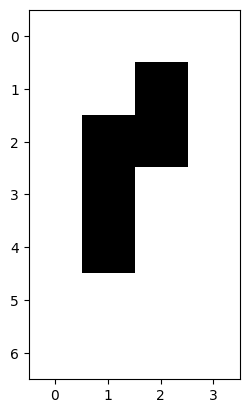

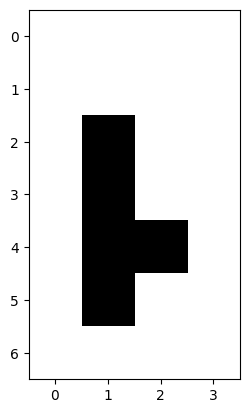

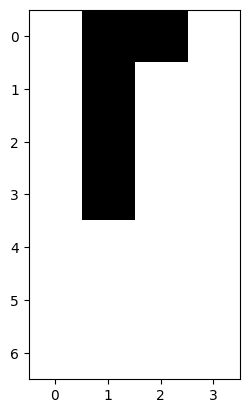

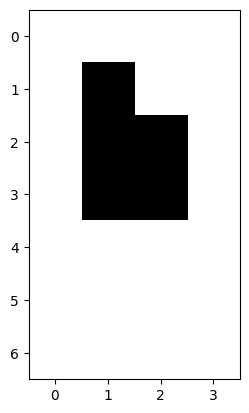

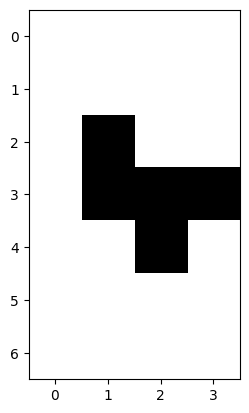

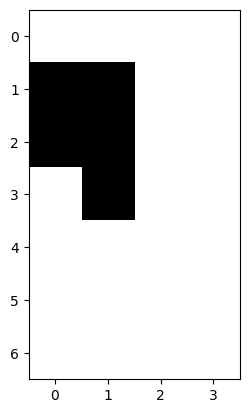

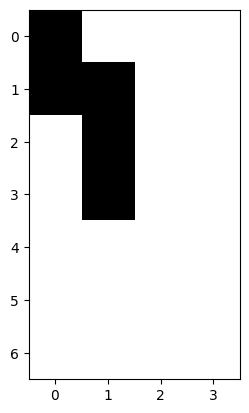

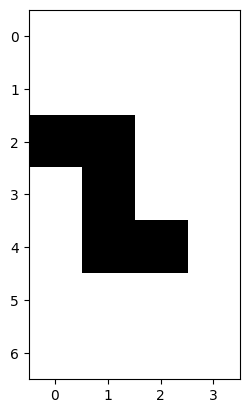

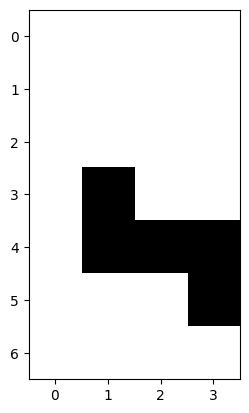

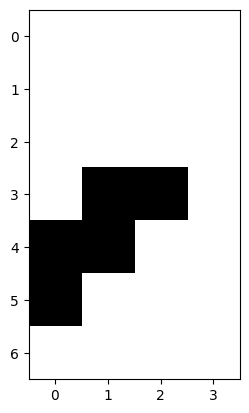

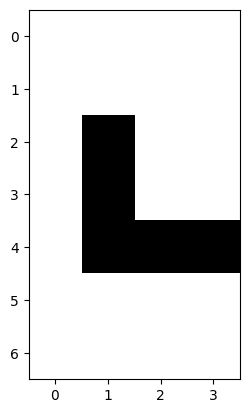

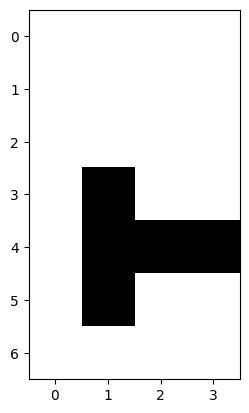

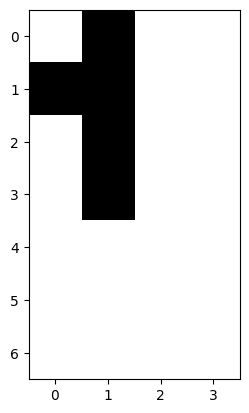

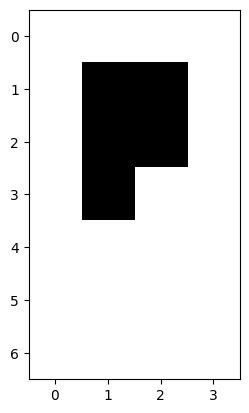

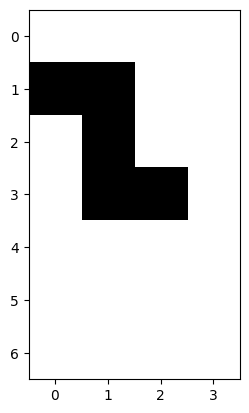

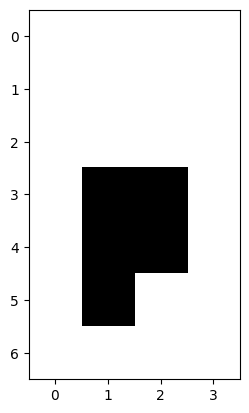

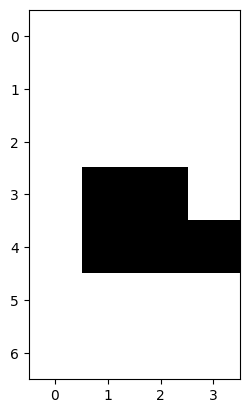

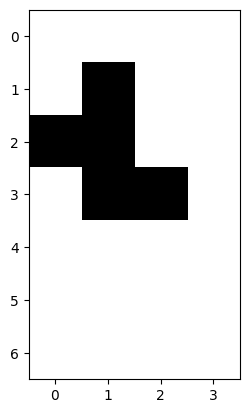

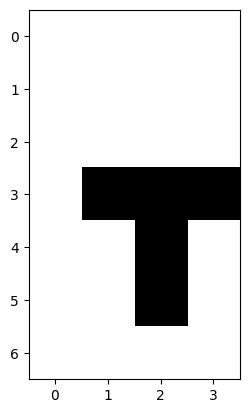

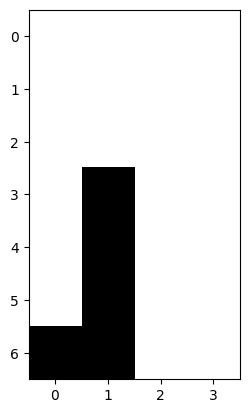

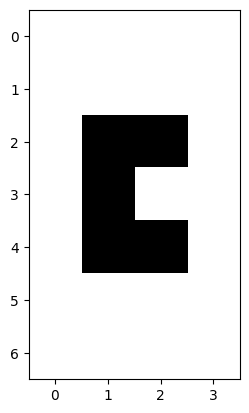

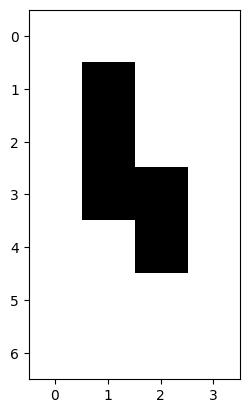

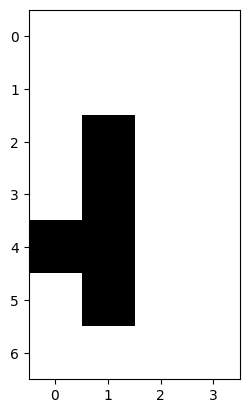

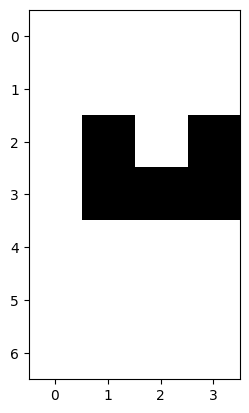

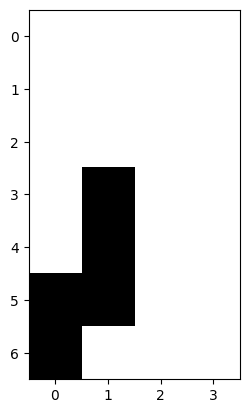

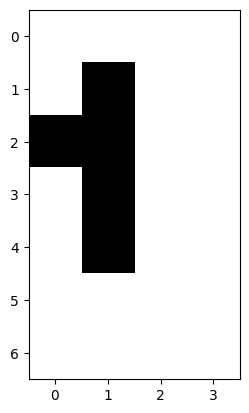

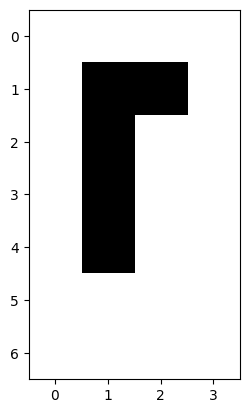

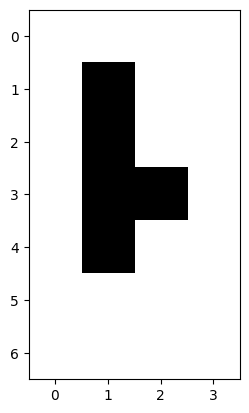

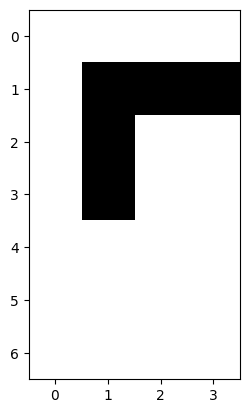

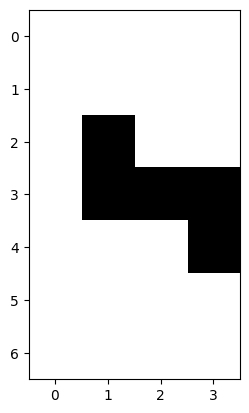

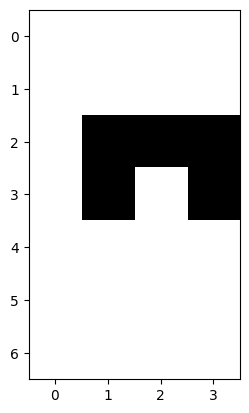

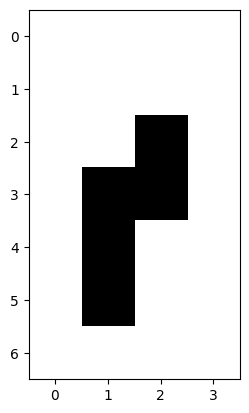

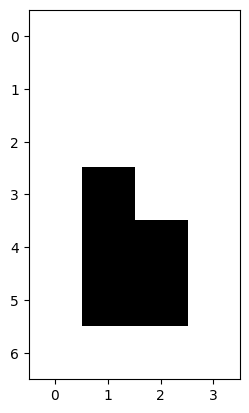

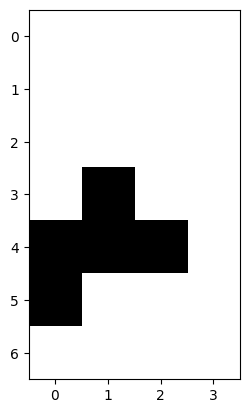

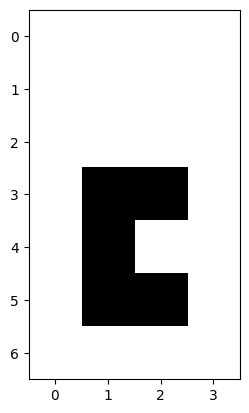

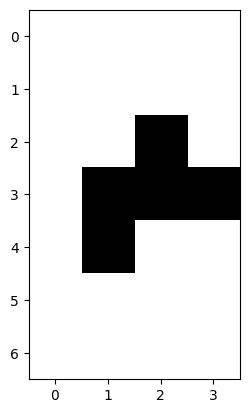

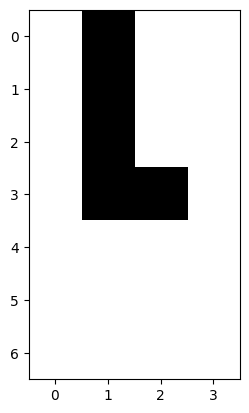

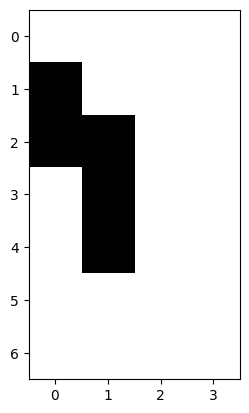

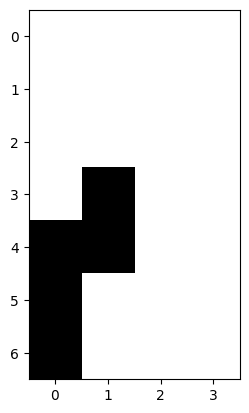

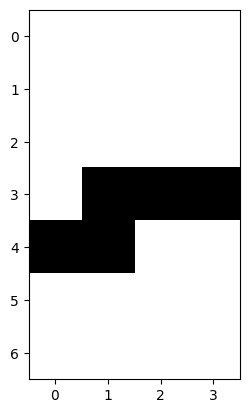

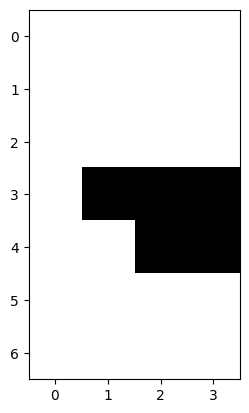

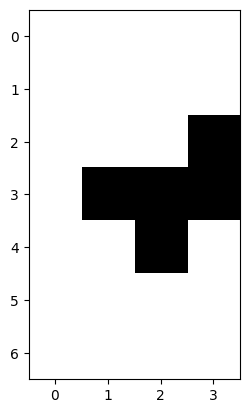

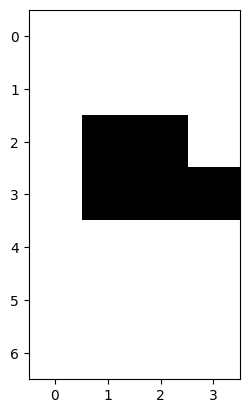

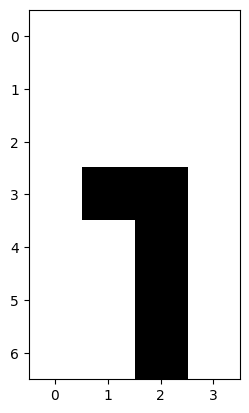

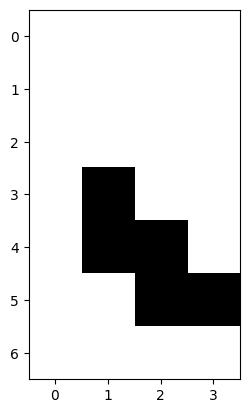

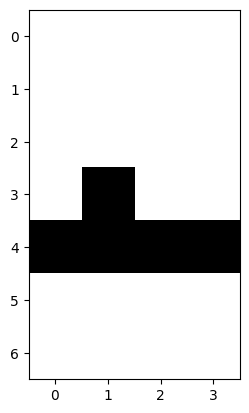

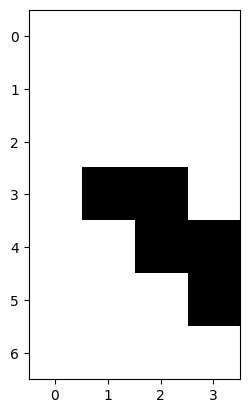

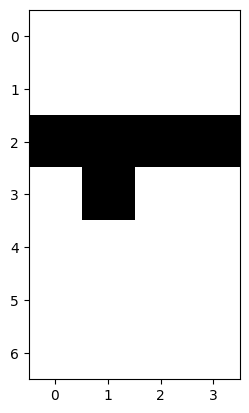

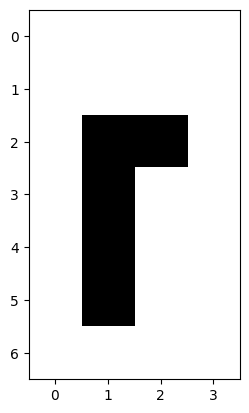

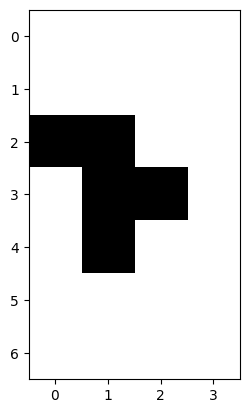

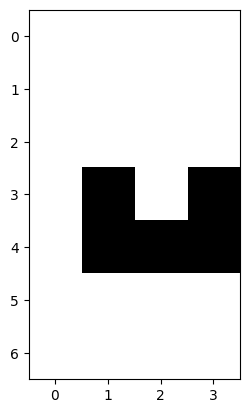

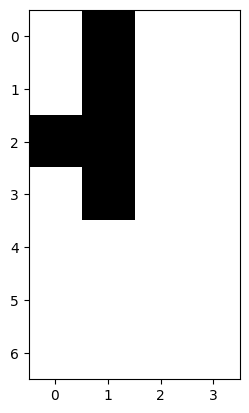

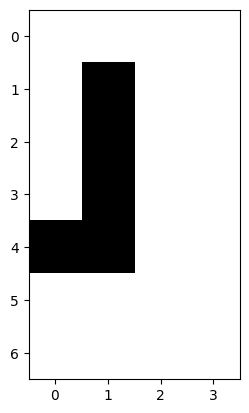

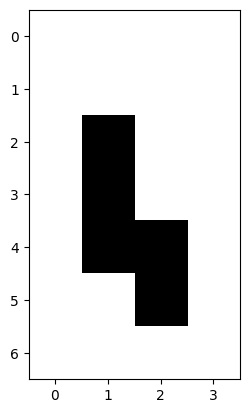

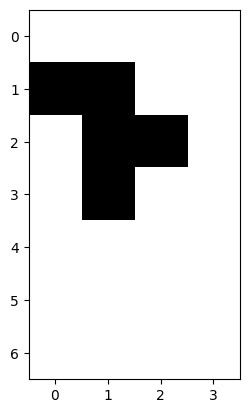

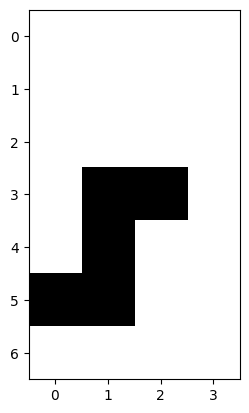

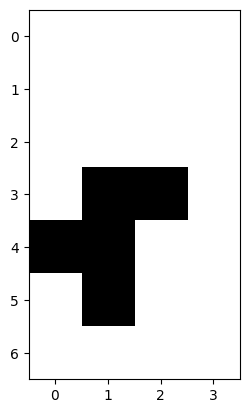

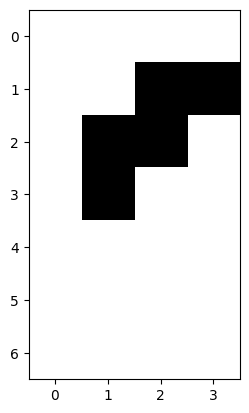

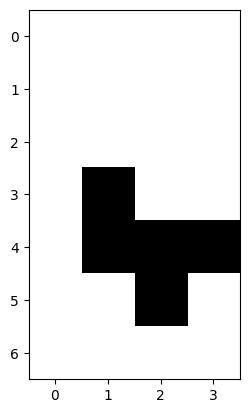

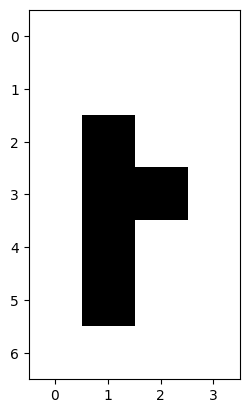

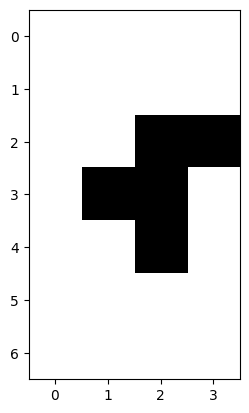

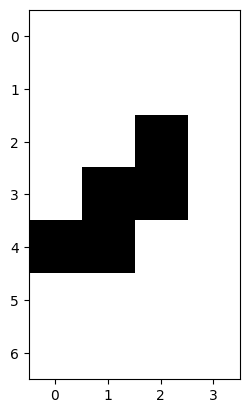

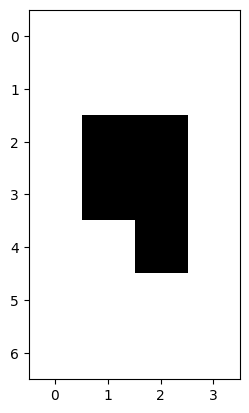

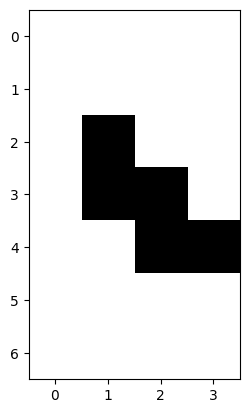

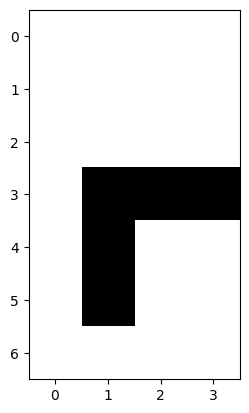

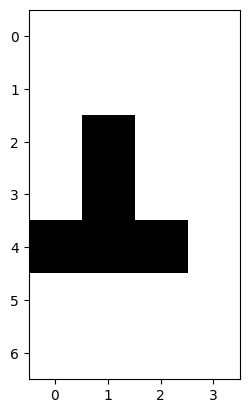

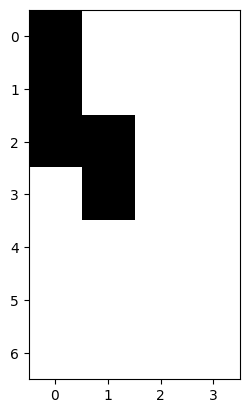

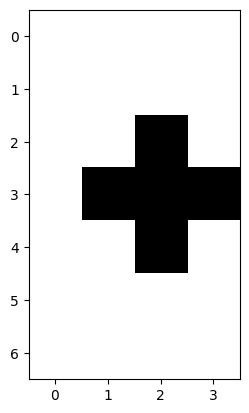

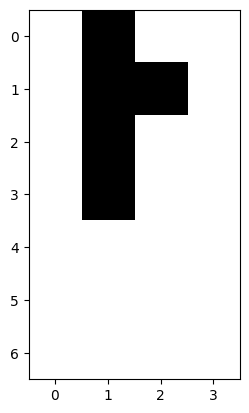

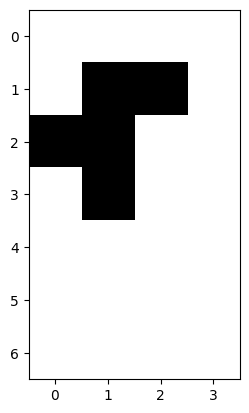

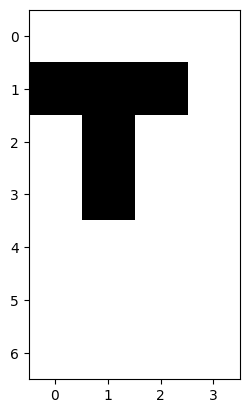

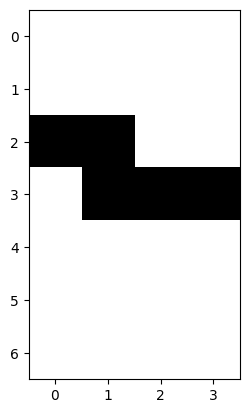

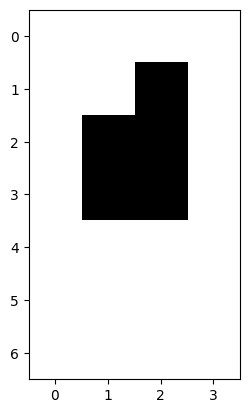

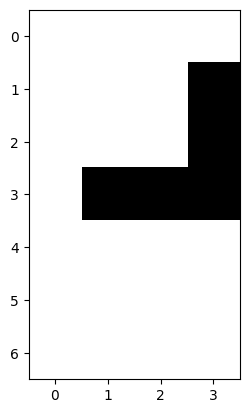

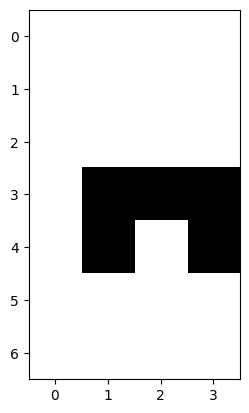

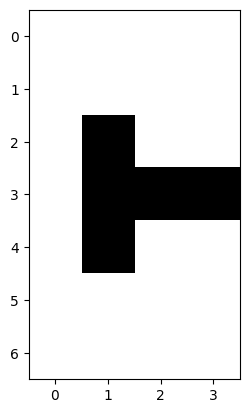

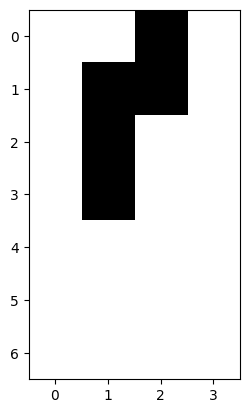

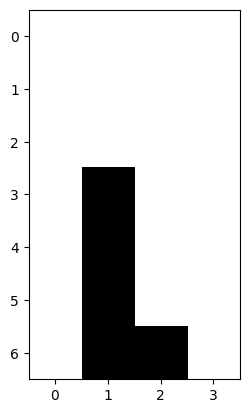

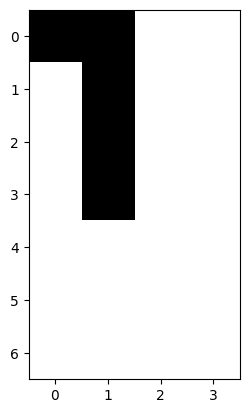

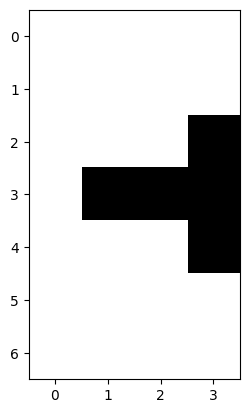

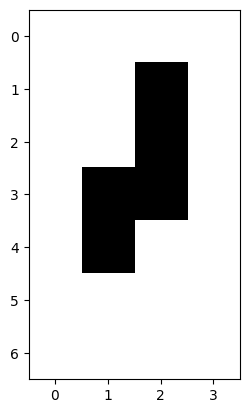

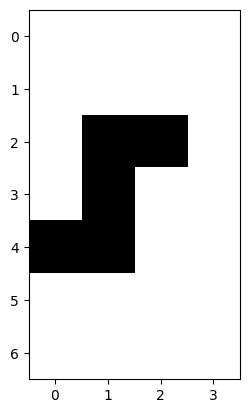

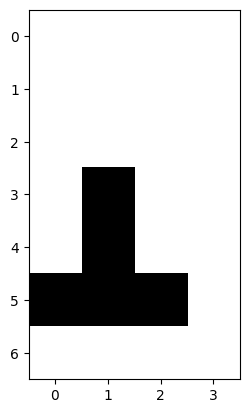

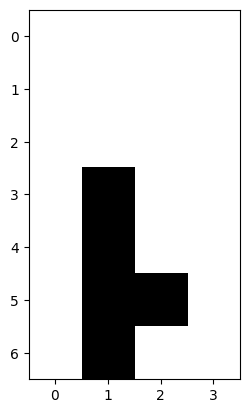

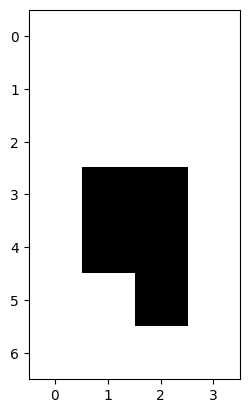

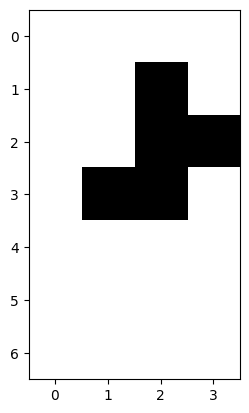

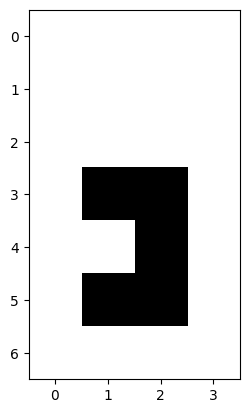

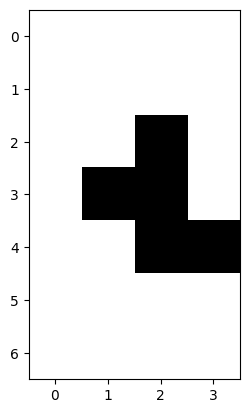

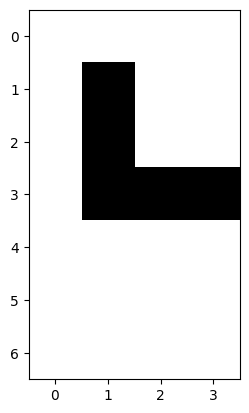

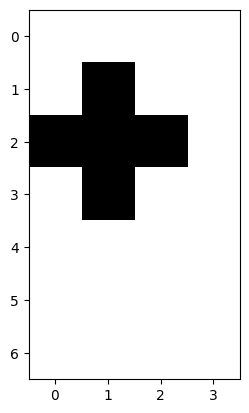

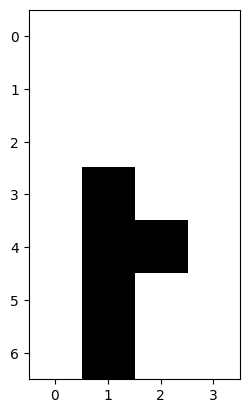

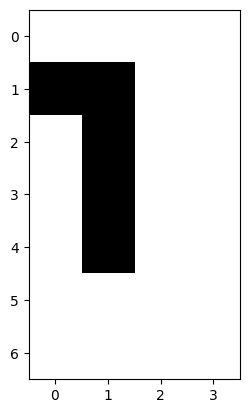

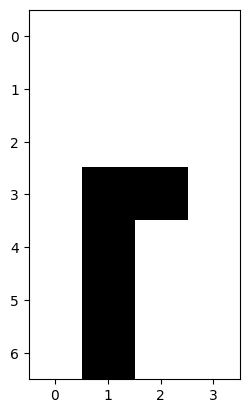

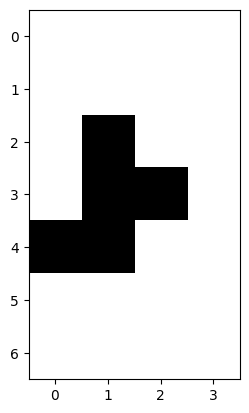

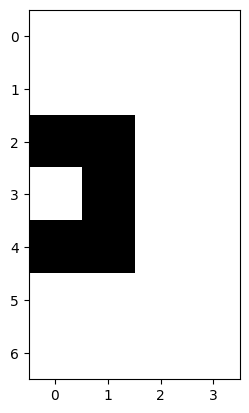

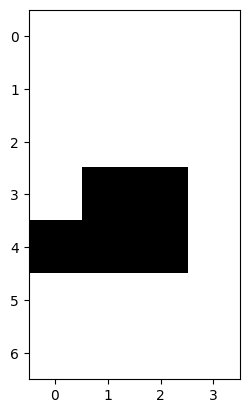

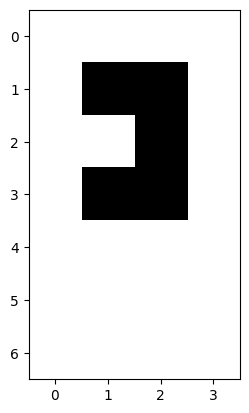

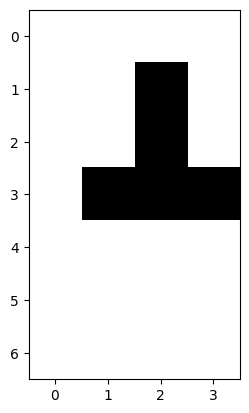

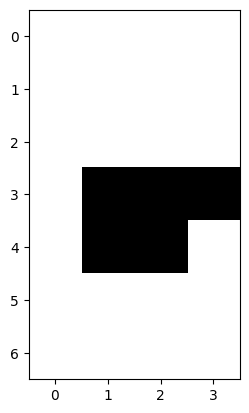

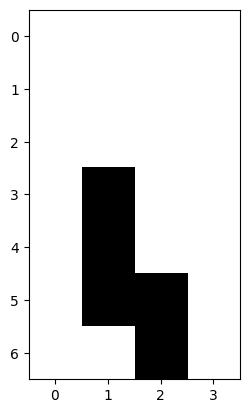

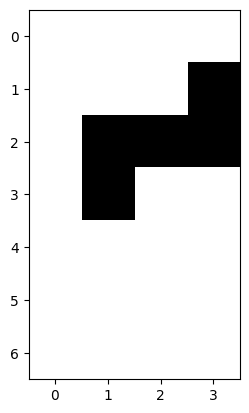

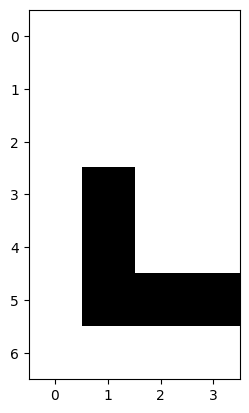

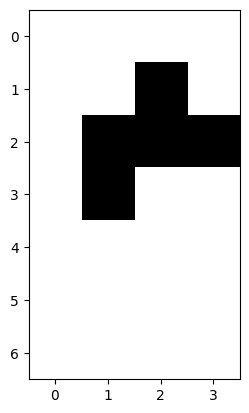

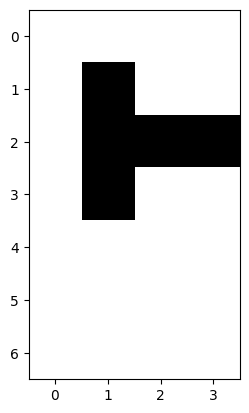

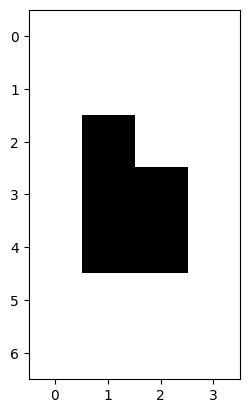

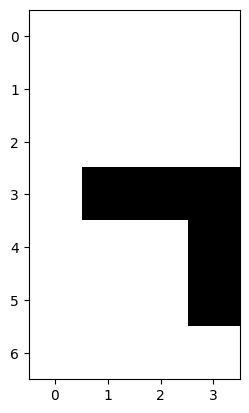

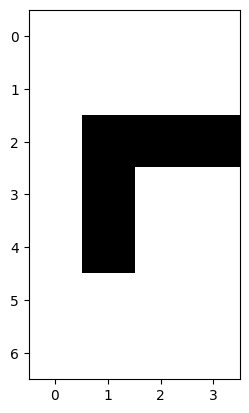

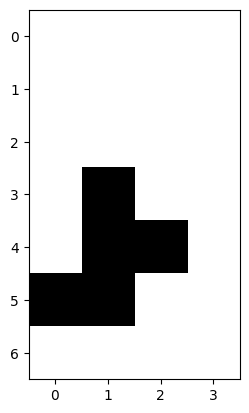

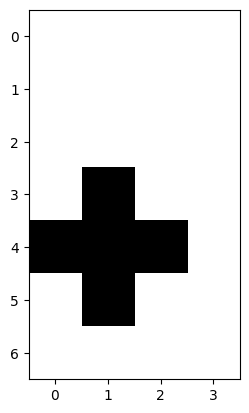

In [261]:
for path in list(all_paths):
    plot_points_on_grid(eval(path), (7,4))

In [274]:
# checking = [eval(path) for path in list(all_paths) if (3,1) in eval(path) and (3,2) in eval(path) and (2,2) in eval(path) and (4,2) in eval(path) and (4,3) in eval(path)]
checking = [eval(path) for path in list(all_paths) if (3,0) in eval(path)]
checking

[]

In [200]:
test = np.array([
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0],
    [ 0,  0,  0,  0]
])
test[3][1] = 1
test[3][2] = 1
test[2][2] = 1
test[4][2] = 1
test[4][3] = 1

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [198]:
sol = [(3,1), (3,2), (2,2), (4,2), (4,3)]
sol.sort()
sol

[(2, 2), (3, 1), (3, 2), (4, 2), (4, 3)]

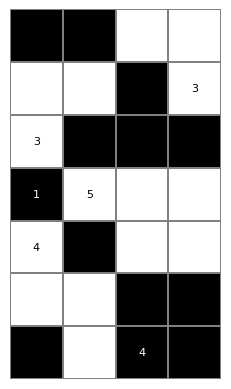

In [188]:
display_grid(solutions[0], reference_grid)

In [100]:
grid = np.array([
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0],
])
location = (0, 0)
n = 3
unique_grids = find_regions(grid, location, n, False)
unique_grids

[array([[-1,  1,  0,  0],
        [-1, -1,  1,  0],
        [ 1,  1,  0,  0],
        [ 0,  0,  0,  0]]),
 array([[-1, -1,  1,  0],
        [ 1, -1,  1,  0],
        [ 0,  1,  0,  0],
        [ 0,  0,  0,  0]]),
 array([[-1, -1, -1,  1],
        [ 1,  1,  1,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]]),
 array([[-1,  1,  0,  0],
        [-1,  1,  0,  0],
        [-1,  1,  0,  0],
        [ 1,  0,  0,  0]])]

In [32]:
import numpy as np
from copy import deepcopy

DIRECTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
reference_grid = [
    [0,6,0,0,0,0,0],
    [0,0,0,0,0,0,3],
    [0,0,0,3,0,0,0],
    [0,0,6,1,5,0,0],
    [0,0,0,4,0,0,0],
    [5,0,0,0,0,0,0],
    [0,0,0,0,0,4,0]
]

def dfs(grid, location, n, path, all_paths):
    # once path is finished, sort all coordinates to check for duplicates
    if len(path) == n:
        sorted_path = sorted(path)
        if sorted_path not in all_paths:
            all_paths.append(sorted_path)
        return

    for dx, dy in DIRECTIONS:
        x, y = location[0] + dx, location[1] + dy

    if 0 <= x < len(grid) \
            and 0 <= y < len(grid[0]) \
            and grid[x][y] == 0 \
            and (x, y) not in path:
            # and (reference_grid[x][y] == 0 or reference_grid[x][y] == n) \
            # :
                
            dfs(grid, (x, y), n, path + [(x, y)], all_paths)

def find_valid_regions(grid, location, n, is_white):
    # Store all unique paths of length n
    all_paths = []
    dfs(grid, location, n, [location], all_paths)

    # Create grids from paths
    unique_grids = []
    for path in all_paths:
        new_grid = np.zeros_like(grid)
        for x, y in path:
            if is_white:
                new_grid[x][y] = 1 # white
            else:
                new_grid[x][y] = -1 # black
        unique_grids.append(new_grid)

    return unique_grids


In [36]:
grid = np.zeros((20,12))
location = (0, 0)
n = 6
unique_grids = find_valid_regions(grid, location, n, True)

# # Print unique grids
# for i, g in enumerate(unique_grids):
#     print(f"Grid #{i+1}:")
#     print(g)
#     print()

unique_grids

[array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0

In [3]:
def populate_grid(grid, coordinate, region_size):
    n = grid.shape[0]
    new_grids = []
    
    def dfs(row, col, count):
        if count == 0:
            new_grids.append(np.copy(grid))
            return
        
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up
        for dr, dc in directions:
            new_row = row + dr
            new_col = col + dc
            if 0 <= new_row < n and 0 <= new_col < n and grid[new_row][new_col] == 0:
                grid[new_row][new_col] = 1
                dfs(new_row, new_col, count - 1)
                grid[new_row][new_col] = 0
    
    row, col = coordinate
    original_value = grid[row][col]
    grid[row][col] = 1
    
    dfs(row, col, region_size - 1)
    
    grid[row][col] = original_value
    
    return new_grids


In [12]:
def knapSack(W, wt, val, n):
    K = [[0 for w in range(W + 1)]
            for i in range(n + 1)]
             
    # Build table K[][] in bottom up manner
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i - 1] <= w:
                K[i][w] = max(val[i - 1] 
                  + K[i - 1][w - wt[i - 1]],
                               K[i - 1][w])
            else:
                K[i][w] = K[i - 1][w]
 
    return K[n][W]
 

# Driver code
val = [60, 100, 120]
wt = [10, 20, 30]
W = 50
n = len(val)
 
print(knapSack(W, wt, val, n))

220


In [13]:
matrix = [
    [0,6,0,0,0,0,0],
    [0,0,0,0,0,0,3],
    [0,0,0,3,0,0,0],
    [0,0,6,1,5,0,0],
    [0,0,0,4,0,0,0],
    [5,0,0,0,0,0,0],
    [0,0,0,0,0,4,0]
]

In [17]:
import numpy as np

def is_rectangular(region):
    rows, cols = zip(*region)
    return min(rows) <= max(rows) and min(cols) <= max(cols)

def region_size(grid, row, col):
    visited = np.full(grid.shape, False, dtype=bool)
    stack = [(row, col)]
    size = 0

    while stack:
        r, c = stack.pop()
        if (0 <= r < grid.shape[0] and 0 <= c < grid.shape[1] and
                not visited[r][c] and grid[r][c] != -1):
            visited[r][c] = True
            size += 1
            stack.extend([(r-1, c), (r+1, c), (r, c-1), (r, c+1)])  # up, down, left, right

    return size

def find_regions(grid, value):
    visited = np.full(grid.shape, False, dtype=bool)
    regions = []
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            if grid[r][c] == value and not visited[r][c]:
                stack = [(r, c)]
                region = []
                while stack:
                    curr_r, curr_c = stack.pop()
                    if (0 <= curr_r < grid.shape[0] and 0 <= curr_c < grid.shape[1] and
                            not visited[curr_r][curr_c] and grid[curr_r][curr_c] == value):
                        visited[curr_r][curr_c] = True
                        region.append((curr_r, curr_c))
                        stack.extend([(curr_r-1, curr_c), (curr_r+1, curr_c), (curr_r, curr_c-1), (curr_r, curr_c+1)])  # up, down, left, right
                regions.append(region)
    return regions

def is_valid(grid, matrix):
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            if matrix[r][c] != 0 and matrix[r][c] != region_size(grid, r, c):
                return False

    shaded_regions = find_regions(grid, 1)
    unshaded_regions = find_regions(grid, 0)

    if any(is_rectangular(region) for region in unshaded_regions):
        return False

    if not all(is_rectangular(region) for region in shaded_regions):
        return False

    return True

def solve(grid, matrix, row, col):
    if row == grid.shape[0]:
        return grid if is_valid(grid, matrix) else None

    next_row, next_col = (row, col + 1) if col != grid.shape[1] - 1 else (row + 1, 0)

    for cell_state in [0, 1]:  # 0 for unshaded, 1 for shaded
        grid[row][col] = cell_state
        if is_valid(grid, matrix):
            result = solve(grid, next_row, next_col)
            if result is not None:  # A valid grid was found
                return result
        grid[row][col] = -1  # Reset cell

    return None  # No valid grid found from this point


In [18]:
matrix = np.array([
    [0,6,0,0,0,0,0],
    [0,0,0,0,0,0,3],
    [0,0,0,3,0,0,0],
    [0,0,6,1,5,0,0],
    [0,0,0,4,0,0,0],
    [5,0,0,0,0,0,0],
    [0,0,0,0,0,4,0]
])

# Create an empty grid with -1 indicating unfilled cells
grid = np.full(matrix.shape, -1, dtype=int)

solution = solve(grid, matrix, 0, 0)

if solution is not None:
    print("Solution found:")
    print(solution)
else:
    print("No solution found.")


No solution found.


In [13]:
import numpy as np

def is_valid(shade_map, matrix):
    # Check validity of each cell
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] > 1:
                if matrix[i][j] % 2 == 0: # Even number must be in a square
                    if not is_rectangle(i, j, matrix, shade_map):
                        return False
                else: # Odd number should be in a straight line
                    if not is_rectangle(i, j, matrix, shade_map):
                        return False
            elif matrix[i][j] == 1: # Cells with 1 should always be shaded
                if shade_map[i][j] != 1:
                    return False

    # Check validity of each shaded/unshaded region
    for i in range(len(shade_map)):
        for j in range(len(shade_map[0])):
            if shade_map[i][j] == 1: # Shaded region must be square
                if not is_rectangle(i, j, matrix, shade_map):
                    return False
            elif shade_map[i][j] == 0: # Unshaded region should not be square
                if is_rectangle(i, j, matrix, shade_map):
                    return False
    return True

def backtrack(matrix, shade_map, pos):
    # If all cells have been filled, return the shade map
    if pos >= len(matrix) * len(matrix[0]):
        if is_valid(shade_map, matrix):
            return shade_map
        else:
            return None

    i = pos // len(matrix[0])
    j = pos % len(matrix[0])

    # Try shading the cell
    shade_map[i][j] = 1
    result = backtrack(matrix, shade_map, pos + 1)
    if result is not None:
        return result

    # If shading the cell didn't lead to a valid solution, try not shading it
    shade_map[i][j] = 0
    result = backtrack(matrix, shade_map, pos + 1)
    if result is not None:
        return result

    # If neither shading nor not shading the cell led to a valid solution, return None
    shade_map[i][j] = -1
    return None

def is_rectangle(i, j, matrix, shade_map):
    n = matrix[i][j]

    # Special case for 0
    if n == 0:
        return True

    factors = get_factors(n)
    for a, b in factors:
        if i + a <= len(matrix) and j + b <= len(matrix[0]):
            if np.all(shade_map[x][j:j+b] == 1 for x in range(i, i + a)):
                return True
        if i + b <= len(matrix) and j + a <= len(matrix[0]):
            if np.all(shade_map[x][j:j+a] == 1 for x in range(i, i + b)):
                return True
    return False


def is_valid(shade_map, matrix):
    # Check validity of each cell
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] > 0:
                if not is_rectangle(i, j, matrix, shade_map):
                    return False

    # Check validity of each shaded/unshaded region
    for i in range(len(shade_map)):
        for j in range(len(shade_map[0])):
            if shade_map[i][j] == 1:  # Shaded region must be rectangular
                if not is_rectangle(i, j, matrix, shade_map):
                    return False
            elif shade_map[i][j] == 0:  # Unshaded region should not be rectangular
                if is_rectangle(i, j, matrix, shade_map):
                    return False
    return True

def get_factors(n):
    # A helper function to return all pairs of factors (a, b) where a*b = n
    factors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            factors.append((i, n // i))
    return factors



def solve(matrix):
    shade_map = np.full(matrix.shape, -1)
    result = backtrack(matrix, shade_map, 0)
    if result is not None:
        print(result)
    else:
        print("No solution found")


In [14]:
matrix = np.array([
    [6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6],
    [6,  0,  0,  0,  0,  0,  0,  0,  0,  8, 12,  0,  0,  0,  0,  0,  0,  0,  0,  6],
    [0,  0,  0, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  0,  0,  0],
    [0,  0,  0, 10,  0,  0, 10, 10,  0,  0,  0,  0, 11, 11,  0,  0,  4,  0,  0,  0],
    [0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
    [0, 15,  0,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,  0,  3,  0],
    [0,  4,  0,  0,  0,  0,  0,  0,  0,  6,  5,  0,  0,  0,  0,  0,  0,  0, 12,  0],
    [0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0],
    [0,  0,  0, 15,  0,  0,  9,  9,  0,  0,  0,  0,  8,  8,  0,  0,  8,  0,  0,  0],
    [0,  0,  0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  7,  0,  0,  0],
    [4,  0,  0,  0,  0,  0,  0,  0,  0, 12,  8,  0,  0,  0,  0,  0,  0,  0,  0,  4],
    [4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4],
])

matrix = np.array([
    [0,6,0,0,0,0,0],
    [0,0,0,0,0,0,3],
    [0,0,0,3,0,0,0],
    [0,0,6,1,5,0,0],
    [0,0,0,4,0,0,0],
    [5,0,0,0,0,0,0],
    [0,0,0,0,0,4,0]
])


matrix = np.array([
    [6,0,0],
    [0,6,0]
])

solve(matrix)

No solution found
